In [1]:
from datetime import datetime
import regex as re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()
countries = {"Germany": "D",
             "Austria": "A",
             "Belgium" : "B",
             "Spain": "E",
             "France": "F",
             "Italy": "I",
             "Luxembourg": "L",
             "Netherlands": "NL"}

### Load Dataset

In [3]:
sorted(os.listdir("Data"))

['2022-11-07_17_50_21_282909.csv',
 '2022-11-07_17_59_56_035522.csv',
 '2022-11-08_12_03_00_239472.csv',
 '2022-11-09_12_36_51_164520.csv',
 '2022-11-09_15_29_31_491597.csv',
 '2022-11-09_21_37_38_614393.csv',
 'visited_urls.json']

In [4]:
file_name = sorted(os.listdir("data")) [0]
file_path = os.path.join("data", file_name)

#df = pd.read_csv(file_path, sep=';', index_col='url')
df = pd.concat([pd.read_csv(os.path.join("data", file),sep=";", index_col='url') for file in os.listdir("data") if file.endswith(".csv")],axis=0,sort=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1997 entries, /annunci/renault-clio-0-9-tci-90-hp-intense-benzina-grigio-6588b7a7-3f64-4471-94fd-8af6ee13ba20 to /annunci/peugeot-307-sw-1-6-hdi-16v-neopatentati-diesel-nero-f984fb5e-a9dd-43bb-901d-53d9f365c780
Data columns (total 98 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Acconto                           1997 non-null   object 
 1   Altezza spazio di carico          1 non-null      object 
 2   Altre fonti energetiche           190 non-null    object 
 3   Anno                              1846 non-null   object 
 4   Anno di produzione                321 non-null    float64
 5   Anticipo                          1563 non-null   object 
 6   Cambio cinghia distribuzione      51 non-null     object 
 7   Carburante                        1819 non-null   object 
 8   Carico utile                      2 non-null      object 
 9   Carrozzeria  

### Rename Index

In [6]:
df['url'] = df.index.str.strip('/annunci/')
df = df.reset_index(drop=True)

### Rename columns

In [7]:
# remove whitespaces and newlines and other characters
df.columns = df.columns.str.replace('\n',' ')
df.columns = df.columns.str.replace(' ','_')
for char in [';', '.', ',', ':', '/', '*']:
    df.columns = df.columns.str.replace(char,'')

col_rename_dict = {
    'Cilindrata':'Cilindrata_cm3',
    'Consumo_di_carburante':'Consumo_di_carburante_kmL',
    'Emissioni_CO₂':'Emissioni_CO2_gKm',
    'Peso_a_vuoto':'Peso_a_vuoto_kg',
    'Usato_garantito':'garanzia_mesi'
}

df = df.rename(columns=col_rename_dict)

print(df.columns)


Index(['Acconto', 'Altezza_spazio_di_carico', 'Altre_fonti_energetiche',
       'Anno', 'Anno_di_produzione', 'Anticipo',
       'Cambio_cinghia_distribuzione', 'Carburante', 'Carico_utile',
       'Carrozzeria', 'Chilometraggio', 'Chilometraggio_pa', 'Cilindrata_cm3',
       'Cilindri', 'Classe_emissioni', 'Colore', 'Colore_finiture_interne',
       'Colore_specifico', 'Comfort', 'Consumo_di_carburante_kmL',
       'Consumo_di_carburante_(WLTP)', 'Consumo_di_energia',
       'Contrassegno_ambientale', 'Costo_del_trasferimento_',
       'Costo_di_registrazione', 'Disponibile_da', 'Durata',
       'Emissioni_CO2_gKm', 'Emissioni_CO₂_(WLTP)', 'Extra',
       'Fattore_di_locazione', 'Importo_da_pagare', 'Importo_da_rimborsare',
       'Importo_finanziato', 'Importo_lordo_del_credito_', 'Importo_rate',
       'Importo_totale_della_locazione', 'Importo_totale_dovuto',
       'Importo_totale_netto_del_credito', 'Interessi_passivi_pagati_pa',
       'Intrattenimento__Media', 'Larghezza_spazio

C:\Users\BESTEN~1\AppData\Local\Temp/ipykernel_15856/1091566063.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace(char,'')


### Remove Useless Columns

In [8]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh", figsize=(12,10))
        plt.show()
    else:
        print('No NAs found')



c:\Users\bestengage\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\bestengage\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


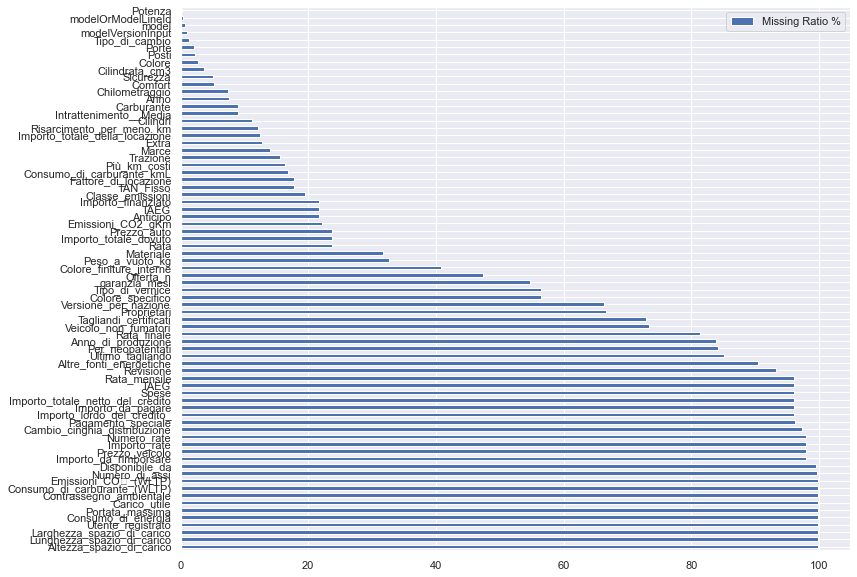

In [9]:
plot_nas(df)

In [10]:
#remove cols with more than 20% values missing, with some exception 
na_df = (df.isnull().sum() / len(df)) * 100      
col_with_na = na_df[na_df>20].index

exclude_from_removal = ['Prezzo_auto', 'Usato_garantito', 'Proprietari', 'Tagliandi_certificati', 'Emissioni_CO2_gKm', 'Peso_a_vuoto_kg', 'garanzia_mesi']
col_to_remove = [el for el in col_with_na if el not in exclude_from_removal]

force_removal = ['Chilometraggio_pa', 'Costo_del_trasferimento_', 'Costo_di_registrazione', 
                    'Fattore_di_locazione', 'Importo_totale_della_locazione', 'Interessi_passivi_pagati_pa', 'Più_km_costi',
                    'Prestito_netto', 'Quota_mensile', 'Risarcimento_per_meno_km', 'TAN_Fisso', 'Tasso_di_interesse_effettivo', 'Totale_unico',
                    'dealer', 'privateSeller', 'Tipo_di_contratto']

col_to_remove = col_to_remove + force_removal

print(col_to_remove, len(col_to_remove))

['Altezza_spazio_di_carico', 'Altre_fonti_energetiche', 'Anno_di_produzione', 'Anticipo', 'Cambio_cinghia_distribuzione', 'Carico_utile', 'Colore_finiture_interne', 'Colore_specifico', 'Consumo_di_carburante_(WLTP)', 'Consumo_di_energia', 'Contrassegno_ambientale', 'Disponibile_da', 'Emissioni_CO₂_(WLTP)', 'Importo_da_pagare', 'Importo_da_rimborsare', 'Importo_finanziato', 'Importo_lordo_del_credito_', 'Importo_rate', 'Importo_totale_dovuto', 'Importo_totale_netto_del_credito', 'Larghezza_spazio_di_carico', 'Lunghezza_spazio_di_carico', 'Materiale', 'Numero_di_assi', 'Numero_rate', 'Offerta_n', 'Pagamento_speciale', 'Per_neopatentati', 'Portata_massima', 'Prezzo_veicolo', 'Rata', 'Rata_finale', 'Rata_mensile', 'Revisione', 'Spese', 'TAEG', 'TAEG', 'Tipo_di_vernice', 'Ultimo_tagliando', 'Utente_registrato', 'Veicolo_non_fumatori', 'Versione_per_nazione', 'Chilometraggio_pa', 'Costo_del_trasferimento_', 'Costo_di_registrazione', 'Fattore_di_locazione', 'Importo_totale_della_locazione', '

In [11]:
col_to_remove = [col for col in col_to_remove if col in df.columns]
df = df.drop(labels=col_to_remove, axis=1)

In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.head())

,Acconto,Anno,Carburante,Carrozzeria,Chilometraggio,Cilindrata_cm3,Cilindri,Classe_emissioni,Colore,Comfort,Consumo_di_carburante_kmL,Durata,Emissioni_CO2_gKm,Extra,Intrattenimento__Media,Marce,Peso_a_vuoto_kg,Porte,Posti,Potenza,Prezzo_auto,Proprietari,Sicurezza,Tagliandi_certificati,Tipo_di_cambio,Tipo_di_veicolo,Trazione,garanzia_mesi,city,country,countryCode,date,makeId,maker,model,modelOrModelLineId,modelVersionInput,price,street,zip,url
0,"€ 0,-",04/2017,Benzina,Berlina,120.398 km,NaN,3.0,Euro 6,Grigio,Chiusura centralizzata senza chiave;Climatizza...,0 l/100 km (comb.)0 l/100 km (urbano)0 l/100 k...,48 Monate,NaN,Cerchi in lega,Autoradio;Bluetooth;MP3;Vivavoce,5.0,NaN,4.0,5.0,66 kW (90 CV),"€ 11.800,-",1.0,ABS;Airbag conducente;Airbag laterali;Airbag p...,NaN,Manuale,Usato,Anteriore,12 mesi,Udine - Ud,Italy,IT,2022-11-07 17:50:40.113020,60,Renault,Clio,1961.0,0.9 TCI 90 HP INTENSE,"€ 11.800,-5",Via Caratti Umberto,33100,renault-clio-0-9-tci-90-hp-intense-benzina-gri...
1,"€ 5.196,-",05/2018,Diesel (Filtro antiparticolato),SUV/Fuoristrada/Pick-up,99.800 km,1.560 cm³,4.0,NaN,Grigio,Alzacristalli elettrici;Bracciolo;Chiusura cen...,"4,4 l/100 km (comb.)4,9 l/100 km (urbano)4,1 l...",42 Monate,114 g/km (comb.),Cerchi in lega;Controllo vocale;Freno di stazi...,Android Auto;Apple CarPlay;Autoradio;Autoradio...,6.0,1.390 kg,5.0,5.0,88 kW (120 CV),"€ 24.900,-",1.0,ABS;Adaptive Cruise Control;Airbag conducente;...,Sì,Automatico,Usato,Anteriore,NaN,Afragola - Na,Italy,IT,2022-11-07 17:50:40.890436,55,Peugeot,3008,19217.0,3008 1.6 bluehdi GT Line eat CAMBIO AUTOMATICO,"€ 24.900,-5",Via A. Mancini,80021,peugeot-3008-3008-1-6-bluehdi-gt-line-eat-camb...
2,"€ 0,-",03/2020,Benzina 91,Station wagon,10.561 km,1.984 cm³,4.0,Euro 6d-TEMP,Argento,Alzacristalli elettrici;Bracciolo;Climatizzato...,"6,1 l/100 km (comb.)7,4 l/100 km (urbano)5,3 l...",42 Monate,133 g/km (comb.),"Cerchi in lega (17"");Controllo vocale;Gancio t...",Android Auto;Apple CarPlay;Bluetooth;Carica pe...,7.0,1.585 kg,5.0,5.0,140 kW (190 CV),NaN,NaN,ABS;Airbag conducente;Airbag laterali;Airbag p...,Sì,Automatico,Usato,Anteriore,24 mesi,Solbiate Olona - Varese - VA,Italy,IT,2022-11-07 17:50:41.749963,9,Audi,A4,1626.0,Avant 40 TFSI 190 CV S tronic Advanced,"€ 36.900,-1, 5",Via Dei Combattenti,21058,di-a4-avant-40-tfsi-190-cv-s-tronic-advanced-b...
3,"€ 0,-",05/2021,Diesel (Filtro antiparticolato),SUV/Fuoristrada/Pick-up,17.000 km,NaN,NaN,Euro 6d-TEMP,Bianco,NaN,NaN,48 Monate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110 kW (150 CV),NaN,1.0,NaN,NaN,Manuale,Usato,4x4,12 mesi,Salerno - Sa,Italy,IT,2022-11-07 17:50:43.447828,13,BMW,X1,19242.0,18D 150CV 6M. E6D-TEMP SS X-DRIVE SPORTLINE (N...,"€ 34.700,-1, 5",Via Roberto Wenner,84100,bmw-x1-18d-150cv-6m-e6d-temp-ss-x-drive-sportl...
4,"€ 5.575,22",11/2016,Diesel,SUV/Fuoristrada/Pick-up,87.000 km,1.685 cm³,4.0,Euro 6,Grigio,Alzacristalli elettrici;Bracciolo;Climatizzato...,"4,9 l/100 km (comb.)5,4 l/100 km (urbano)4,7 l...",36 Monate,129 g/km (comb.),"Cerchi in lega (17"");Freno di stazionamento el...",Autoradio;Bluetooth;CD;Computer di bordo;MP3;U...,7.0,1.545 kg,5.0,5.0,104 kW (141 CV),"€ 18.900,-",1.0,ABS;Airbag conducente;Airbag laterali;Airbag p...,NaN,Automatico,Usato,Anteriore,NaN,Pistoia - Pt,Italy,IT,2022-11-07 17:50:44.064556,33,Hyundai,TUCSON,18493.0,1.7 CRDi DCT Auto XPossible,"€ 18.900,-5","Vial Manzoni 27""}",51100,hyundai-tucson-1-7-crdi-dct-auto-xpossible-die...


### Data extraction from text

In [13]:
price_pat = r'\€\s*(\d*),*'
km_pat = r'(\d*)\s*km'
pot_kw_pat = r'(\d*)\s*kW'
pot_cv_pat = r'\((\d*)\s*CV\)'
cil_cm3_pat = r'(\d*)\s*cm'
weight_kg_pat = r'(\d*)\s*kg'
emis_gkm_comb_pat = r'(\d*)\s*g/km\s*\(comb'
garanzia_mesi_pat = r'(\d*)\s*mesi'
consumo_comb_kmL_pat = r'(\d+\.?\d*)\sl/100\skm\s\(comb'
consumo_urb_kmL_pat = r'(\d+\.?\d*)\sl/100\skm\s\(urb'
consumo_extraurb_kmL_pat = r'(\d+\.?\d*)\sl/100\skm\s\(extraurb'


In [14]:
km_columns = ['Chilometraggio']
price_columns = ['Prezzo_auto', 'price', 'Acconto']

In [15]:

for col in km_columns:
    df[col] = df[col].str.replace('.', '').str.extract(pat=km_pat).astype(np.float64)

for col in price_columns:
    df[col] = df[col].str.replace('.', '').str.extract(pat=price_pat).astype(np.float64)

df['Cilindrata_cm3'] = df['Cilindrata_cm3'].str.replace('.', '').str.extract(pat=cil_cm3_pat).astype(np.float64)
df['potenza_kw'] = df['Potenza'].str.replace('.', '').str.extract(pat=pot_kw_pat).astype(np.float64)
df['potenza_cv'] = df['Potenza'].str.replace('.', '').str.extract(pat=pot_cv_pat).astype(np.float64)

df['Peso_a_vuoto_kg'] = df['Peso_a_vuoto_kg'].str.replace('.', '').str.extract(pat=weight_kg_pat).astype(np.float64)
df['Emissioni_CO2_gKm'] = df['Emissioni_CO2_gKm'].str.replace('.', '').str.extract(pat=emis_gkm_comb_pat).astype(np.float64)
df['garanzia_mesi'] = df['garanzia_mesi'].str.extract(pat=garanzia_mesi_pat).astype(np.float64)

df['Consumo_comb_kmL'] = df['Consumo_di_carburante_kmL'].str.replace(',', '.').str.extract(pat=consumo_comb_kmL_pat,expand=False).astype(np.float64)
df['Consumo_urb_kmL'] = df['Consumo_di_carburante_kmL'].str.replace(',', '.').str.extract(pat=consumo_urb_kmL_pat,expand=False).astype(np.float64)
df['Consumo_extraurb_kmL'] = df['Consumo_di_carburante_kmL'].str.replace(',', '.').str.extract(pat=consumo_extraurb_kmL_pat,expand=False).astype(np.float64)

df = df.drop(columns=['Potenza', 'Consumo_di_carburante_kmL'])

C:\Users\BESTEN~1\AppData\Local\Temp/ipykernel_15856/922964951.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('.', '').str.extract(pat=km_pat).astype(np.float64)
C:\Users\BESTEN~1\AppData\Local\Temp/ipykernel_15856/922964951.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('.', '').str.extract(pat=price_pat).astype(np.float64)
C:\Users\BESTEN~1\AppData\Local\Temp/ipykernel_15856/922964951.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Cilindrata

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.head())

,Acconto,Anno,Carburante,Carrozzeria,Chilometraggio,Cilindrata_cm3,Cilindri,Classe_emissioni,Colore,Comfort,Durata,Emissioni_CO2_gKm,Extra,Intrattenimento__Media,Marce,Peso_a_vuoto_kg,Porte,Posti,Prezzo_auto,Proprietari,Sicurezza,Tagliandi_certificati,Tipo_di_cambio,Tipo_di_veicolo,Trazione,garanzia_mesi,city,country,countryCode,date,makeId,maker,model,modelOrModelLineId,modelVersionInput,price,street,zip,url,potenza_kw,potenza_cv,Consumo_comb_kmL,Consumo_urb_kmL,Consumo_extraurb_kmL
0,0.0,04/2017,Benzina,Berlina,120398.0,NaN,3.0,Euro 6,Grigio,Chiusura centralizzata senza chiave;Climatizza...,48 Monate,NaN,Cerchi in lega,Autoradio;Bluetooth;MP3;Vivavoce,5.0,NaN,4.0,5.0,11800.0,1.0,ABS;Airbag conducente;Airbag laterali;Airbag p...,NaN,Manuale,Usato,Anteriore,12.0,Udine - Ud,Italy,IT,2022-11-07 17:50:40.113020,60,Renault,Clio,1961.0,0.9 TCI 90 HP INTENSE,11800.0,Via Caratti Umberto,33100,renault-clio-0-9-tci-90-hp-intense-benzina-gri...,66.0,90.0,0.0,0.0,0.0
1,5196.0,05/2018,Diesel (Filtro antiparticolato),SUV/Fuoristrada/Pick-up,99800.0,1560.0,4.0,NaN,Grigio,Alzacristalli elettrici;Bracciolo;Chiusura cen...,42 Monate,114.0,Cerchi in lega;Controllo vocale;Freno di stazi...,Android Auto;Apple CarPlay;Autoradio;Autoradio...,6.0,1390.0,5.0,5.0,24900.0,1.0,ABS;Adaptive Cruise Control;Airbag conducente;...,Sì,Automatico,Usato,Anteriore,NaN,Afragola - Na,Italy,IT,2022-11-07 17:50:40.890436,55,Peugeot,3008,19217.0,3008 1.6 bluehdi GT Line eat CAMBIO AUTOMATICO,24900.0,Via A. Mancini,80021,peugeot-3008-3008-1-6-bluehdi-gt-line-eat-camb...,88.0,120.0,4.4,4.9,4.1
2,0.0,03/2020,Benzina 91,Station wagon,10561.0,1984.0,4.0,Euro 6d-TEMP,Argento,Alzacristalli elettrici;Bracciolo;Climatizzato...,42 Monate,133.0,"Cerchi in lega (17"");Controllo vocale;Gancio t...",Android Auto;Apple CarPlay;Bluetooth;Carica pe...,7.0,1585.0,5.0,5.0,NaN,NaN,ABS;Airbag conducente;Airbag laterali;Airbag p...,Sì,Automatico,Usato,Anteriore,24.0,Solbiate Olona - Varese - VA,Italy,IT,2022-11-07 17:50:41.749963,9,Audi,A4,1626.0,Avant 40 TFSI 190 CV S tronic Advanced,36900.0,Via Dei Combattenti,21058,di-a4-avant-40-tfsi-190-cv-s-tronic-advanced-b...,140.0,190.0,6.1,7.4,5.3
3,0.0,05/2021,Diesel (Filtro antiparticolato),SUV/Fuoristrada/Pick-up,17000.0,NaN,NaN,Euro 6d-TEMP,Bianco,NaN,48 Monate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Manuale,Usato,4x4,12.0,Salerno - Sa,Italy,IT,2022-11-07 17:50:43.447828,13,BMW,X1,19242.0,18D 150CV 6M. E6D-TEMP SS X-DRIVE SPORTLINE (N...,34700.0,Via Roberto Wenner,84100,bmw-x1-18d-150cv-6m-e6d-temp-ss-x-drive-sportl...,110.0,150.0,NaN,NaN,NaN
4,5575.0,11/2016,Diesel,SUV/Fuoristrada/Pick-up,87000.0,1685.0,4.0,Euro 6,Grigio,Alzacristalli elettrici;Bracciolo;Climatizzato...,36 Monate,129.0,"Cerchi in lega (17"");Freno di stazionamento el...",Autoradio;Bluetooth;CD;Computer di bordo;MP3;U...,7.0,1545.0,5.0,5.0,18900.0,1.0,ABS;Airbag conducente;Airbag laterali;Airbag p...,NaN,Automatico,Usato,Anteriore,NaN,Pistoia - Pt,Italy,IT,2022-11-07 17:50:44.064556,33,Hyundai,TUCSON,18493.0,1.7 CRDi DCT Auto XPossible,18900.0,"Vial Manzoni 27""}",51100,hyundai-tucson-1-7-crdi-dct-auto-xpossible-die...,104.0,141.0,4.9,5.4,4.7


<AxesSubplot:>

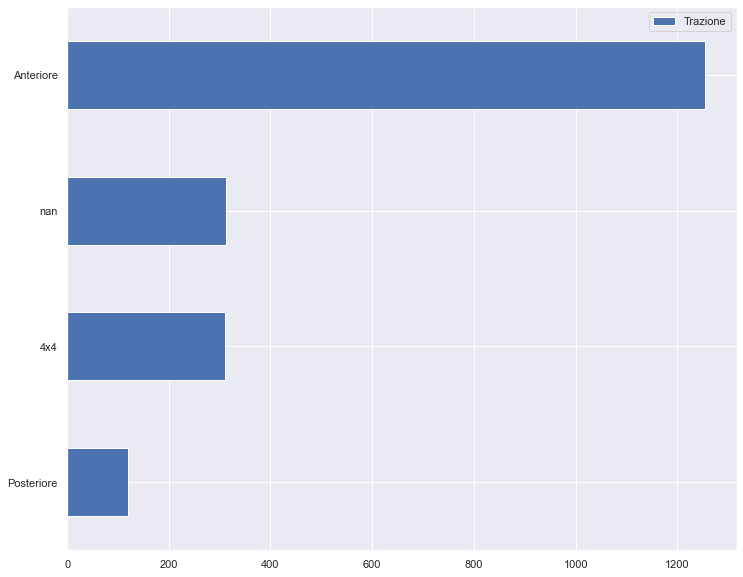

In [17]:
col = 'Trazione'
col_counts = df[col].value_counts(dropna=False)
pd.DataFrame({f'{col}' :col_counts[::-1]}).plot(kind='barh', figsize=(12, 10))